In [1]:
import os
import math
import json
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------- Core parameters (STOI defaults) ----------
FS = 10_000               # downsampled sampling rate
WIN_LEN = 256             # samples (~25.6 ms @ 10 kHz)
HOP_LEN = 128             # 50% overlap
N_FFT = 512               # zero padding for finer bin grouping
N_SEG = 30                # frames per temporal envelope vector (~30 * 12.8ms ≈ 384 ms)
BETA_DB = 15.0            # STOI clipping threshold (15 dB)
EPS = 1e-12

# ---------- 1/3-octave bands for STOI ----------
F_MIN = 150.0
F_MAX = 4300.0
K_1_3 = 2.0 ** (1.0 / 3.0)
K_1_6 = 2.0 ** (1.0 / 6.0)  # for edges

# SA-STOI uses ONLY the highest three one-third-octave bands (indices 13..15 at 10 kHz)
TOP3_BAND_COUNT = 3


In [2]:
def load_mono_resample(path: str, target_sr: int = FS):
    """Load, mono, resample to target_sr, remove DC."""
    x, sr = sf.read(path, always_2d=False)
    if x.ndim > 1:
        x = x.mean(axis=1)
    if sr != target_sr:
        x = librosa.resample(x.astype(np.float32), orig_sr=sr, target_sr=target_sr)
    x = x.astype(np.float32)
    x -= np.mean(x)
    return x, target_sr

def match_lengths(a: np.ndarray, b: np.ndarray):
    L = min(len(a), len(b))
    return a[:L], b[:L]


In [3]:
# --- NEW CELL: create vocal_dir stems from unprocessed mixes ---

import subprocess
import pathlib

VOCAL_DIR = "train/vocals"
UNPROC_DIR = "train/unprocessed"

pathlib.Path(VOCAL_DIR).mkdir(parents=True, exist_ok=True)

def stem_path(signal_id: str) -> str:
    return os.path.join(VOCAL_DIR, f"{signal_id}.flac")

def unproc_path(signal_id: str, suffix="_unproc.flac") -> str:
    return os.path.join(UNPROC_DIR, f"{signal_id}{suffix}")

def ensure_vocal_stem(signal_id: str, separator="demucs", model="htdemucs"):
    """
    If the vocal stem for <signal_id> is missing, run a separator on the
    *unprocessed* mix to create it, and save as train/vocals/<id>.flac.
    Replace the body with your preferred tool/CLI.
    """
    out_path = stem_path(signal_id)
    if os.path.exists(out_path):
        return out_path

    mix_path = unproc_path(signal_id)
    if not os.path.exists(mix_path):
        raise FileNotFoundError(f"Unprocessed mix not found: {mix_path}")

    # --- Example using Demucs CLI (adjust to your environment):
    # Creates a folder (e.g., ./separated/htdemucs/<file>/vocals.wav)
    # You can install: pip install demucs
    cmd = [
        "python", "-m", "demucs", "-n", model, "--two-stems", "vocals",
        "--out", "separated", mix_path
    ]
    print("Separating vocals:", " ".join(cmd))
    subprocess.run(cmd, check=True)

    # Move/convert the produced vocals file into train/vocals/<id>.flac
    # Demucs outputs wav; we’ll load+rewrite as flac for consistency:
    # (Find the produced path)
    base = os.path.splitext(os.path.basename(mix_path))[0]
    produced = os.path.join("separated", model, base, "vocals.wav")
    if not os.path.exists(produced):
        raise FileNotFoundError("Expected Demucs output not found: " + produced)

    # Save as FLAC in our canonical place
    import soundfile as sf
    v, sr = sf.read(produced, always_2d=False)
    sf.write(out_path, v, sr, format="FLAC")
    return out_path


In [4]:
def third_octave_centers(f0=F_MIN, fmax=F_MAX):
    """Generate third-octave center frequencies from f0 to ~fmax."""
    centers = []
    fc = f0
    while fc <= fmax * 1.001:
        centers.append(fc)
        fc *= K_1_3
    return centers  # ~15 centers at 10 kHz

def third_octave_edges(fc):
    """Edges for a one-third-oct band: [fc/K_1_6, fc*K_1_6]."""
    return fc / K_1_6, fc * K_1_6

def make_band_binmap(sr=FS, n_fft=N_FFT):
    """
    Map each 1/3-octave band to FFT bin indices (positive freqs).
    Returns: bands (list of (start_idx, end_idx)), centers (list of fc).
    """
    centers = third_octave_centers()
    freqs = np.fft.rfftfreq(n_fft, d=1.0/sr)  # size n_fft//2 + 1
    bands = []
    for fc in centers:
        f1, f2 = third_octave_edges(fc)
        # clip to (0, Nyquist]
        f1 = max(0.0, f1)
        f2 = min(sr/2.0, f2)
        # bin range
        idx1 = np.searchsorted(freqs, f1, side='left')
        idx2 = np.searchsorted(freqs, f2, side='right')  # exclusive
        if idx2 - idx1 >= 1:
            bands.append((idx1, idx2))
        else:
            bands.append(None)  # unusable (should not happen with chosen params)
    # Drop any None bands and keep matched centers
    valid = [(b, c) for b, c in zip(bands, centers) if b is not None]
    bands, centers = zip(*valid)
    return list(bands), list(centers)


In [5]:
def stft_mag(x: np.ndarray, sr=FS, n_fft=N_FFT, win_len=WIN_LEN, hop_len=HOP_LEN):
    """
    Returns magnitude STFT: shape (freq_bins, frames)
    """
    window = np.hanning(win_len)
    S = librosa.stft(
        x, n_fft=n_fft, hop_length=hop_len, win_length=win_len, window=window, center=True
    )  # complex
    return np.abs(S)

def band_envelopes_from_mag(S_mag: np.ndarray, bands_binmap):
    """
    Sum magnitudes within each band per frame to form 'envelopes' (STOI TF-units).
    Returns: E (bands, frames) where E[j, m] = sqrt(sum_k |S[k,m]|^2 over band bins)
    """
    B = len(bands_binmap)
    T = S_mag.shape[1]
    E = np.zeros((B, T), dtype=np.float32)
    for j, (i1, i2) in enumerate(bands_binmap):
        # Power sum over bins in band, then sqrt → band 'envelope' (STOI style)
        band_power = np.sum(S_mag[i1:i2, :]**2, axis=0)
        E[j, :] = np.sqrt(band_power + EPS)
    return E  # (B, T)


In [6]:
def vocal_active_mask_from_vocal_S(S_mag_vocal: np.ndarray, min_run_frames: int = 5):
    """
    Approximate the paper's vocal-active selection:
    - Split frequency axis into 4 equal parts; take the 2nd part's energy per frame.
    - Threshold at median (or tweakable factor); keep frames above threshold.
    - Enforce a minimum run length to avoid pepper-noise.
    Returns: boolean mask of shape (frames,)
    """
    F, T = S_mag_vocal.shape
    q1, q2, q3 = F//4, F//2, 3*F//4
    # 2nd sub-band: [q1:q2)
    sub2_energy = np.sum(S_mag_vocal[q1:q2, :]**2, axis=0)
    thr = np.median(sub2_energy)  # you may set e.g. 0.8 * median, etc.
    raw_mask = sub2_energy > thr

    # enforce minimum run length
    mask = raw_mask.copy()
    count = 0
    for t in range(T):
        if raw_mask[t]:
            count += 1
        else:
            if 0 < count < min_run_frames:
                mask[t-count:t] = False
            count = 0
    # tail
    if 0 < count < min_run_frames:
        mask[T-count:T] = False

    return mask


In [7]:
def stoi_temporal_corrs(E_ref: np.ndarray, E_mix: np.ndarray,
                        n_seg=N_SEG, beta_db=BETA_DB):
    """
    Compute per-(band,frame) STOI correlations.
    Inputs:
      E_ref, E_mix: (B, T) band envelopes for reference and test (mix)
    Returns:
      D: (B, T) with NaN where not computed; correlations elsewhere in [-1,1]
    """
    B, T = E_ref.shape
    D = np.full((B, T), np.nan, dtype=np.float32)
    clip_scale = 1.0 + 10.0 ** (-beta_db / 20.0)

    for j in range(B):
        for m in range(n_seg-1, T):
            xr = E_ref[j, m-n_seg+1:m+1]
            yd = E_mix[j, m-n_seg+1:m+1]

            # Drop if reference energy too low
            nr = np.linalg.norm(xr)
            ny = np.linalg.norm(yd)
            if nr < 1e-6 or ny < 1e-9:
                continue

            # Normalize Y to X
            yd = yd * (nr / (ny + EPS))

            # Clipping
            yd = np.minimum(yd, clip_scale * xr)

            # Pearson correlation (mean/std normalize)
            xr_z = (xr - xr.mean()) / (xr.std() + EPS)
            yd_z = (yd - yd.mean()) / (yd.std() + EPS)
            corr = float(np.dot(xr_z, yd_z) / len(xr))
            D[j, m] = np.clip(corr, -1.0, 1.0)

    return D  # (B, T) with NaNs where invalid


In [8]:
def sa_stoi_from_corrs(D: np.ndarray, centers_hz: list, vocal_mask: np.ndarray):
    """
    Compute singing-adapted STOI:
    - keep ONLY the top-3 one-third-octave bands (highest center freqs)
    - average d_j(m) over those bands and over frames where vocal_mask is True.
    D: (B, T) correlations in [-1,1] with NaNs where invalid
    centers_hz: list of length B
    vocal_mask: boolean array length T
    Returns scalar in [-1,1], typically reported or interpreted in [0,1] range.
    """
    # pick top-3 bands by center frequency
    order = np.argsort(centers_hz)  # ascending
    top3_idx = order[-TOP3_BAND_COUNT:]

    # mask frames: vocal active & not NaN
    vals = []
    for j in top3_idx:
        dj = D[j, :]
        ok = np.isfinite(dj) & vocal_mask
        vals.append(dj[ok])
    if len(vals) == 0:
        return np.nan
    vals = np.concatenate([v for v in vals if v.size > 0], axis=0)
    if vals.size == 0:
        return np.nan
    # average correlations; optionally map to [0,1] if desired
    return float(np.nanmean(vals))


In [9]:
def compute_sa_stoi_for_pair(ref_path: str, mix_path: str):
    # 1) Load, mono, 10 kHz, DC removed
    ref, _ = load_mono_resample(ref_path, FS)
    mix, _ = load_mono_resample(mix_path, FS)
    ref, mix = match_lengths(ref, mix)

    # 2) STFT magnitudes
    S_ref = stft_mag(ref, sr=FS, n_fft=N_FFT, win_len=WIN_LEN, hop_len=HOP_LEN)  # (F, T)
    S_mix = stft_mag(mix, sr=FS, n_fft=N_FFT, win_len=WIN_LEN, hop_len=HOP_LEN)  # (F, T)

    # 3) Band bin map & per-band envelopes
    bands, centers = make_band_binmap(sr=FS, n_fft=N_FFT)         # list of (i1,i2), length B
    E_ref = band_envelopes_from_mag(S_ref, bands)                  # (B, T)
    E_mix = band_envelopes_from_mag(S_mix, bands)                  # (B, T)

    # 4) Vocal-active frames from the vocal stem (paper-style)
    vocal_mask = vocal_active_mask_from_vocal_S(S_ref, min_run_frames=5)  # (T,)

    # 5) STOI correlations per band & frame (using temporal vectors)
    D = stoi_temporal_corrs(E_ref, E_mix, n_seg=N_SEG, beta_db=BETA_DB)   # (B, T)

    # 6) SA-STOI aggregation: only top-3 bands & only vocal-active frames
    d = sa_stoi_from_corrs(D, centers_hz=centers, vocal_mask=vocal_mask)  # in [-1,1]
    # Optional: map to [0,1]
    d01 = 0.5 * (d + 1.0) if np.isfinite(d) else np.nan
    return d01


In [10]:
def batch_sa_stoi_from_metadata(meta_path: str,
                                vocal_dir: str = "train/vocals",
                                mix_dir: str = "train/unprocessed",
                                vocal_suffix: str = ".flac",
                                mix_suffix: str = "_unproc.flac"):
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

    results = []
    for item in tqdm(meta):
        sid = item["signal"]
        ref_path = stem_path(sid)  # where we cache stems
        if not os.path.exists(ref_path):
            try:
                ref_path = ensure_vocal_stem(sid)  # builds vocals from UNPROC once
            except Exception as e:
                rec["sa_stoi"] = np.nan
                if compute_baseline_stoi: rec["stoi_baseline"] = np.nan
                rows.append(rec)
                continue
        
        mix_path = os.path.join(mix_dir, f"{sid}{mix_suffix}")
        if not (os.path.exists(ref_path) and os.path.exists(mix_path)):
            results.append({**item, "sa_stoi": np.nan})
            continue
        score = compute_sa_stoi_for_pair(ref_path, mix_path)
        results.append({**item, "sa_stoi": score})

    return results

# Example:
# results = batch_sa_stoi_from_metadata("metadata/train_metadata.json",
#                                       vocal_dir="train/vocals",
#                                       mix_dir="train/unprocessed")
# import pandas as pd
# df = pd.DataFrame(results)
# display(df.head())


In [11]:
# 1) Band centers and which three are used
bands, centers = make_band_binmap(sr=FS, n_fft=N_FFT)
print("Band centers (Hz):", np.round(centers, 1))
print("Top-3 centers used:", np.round(sorted(centers)[-3:], 1))

# 2) Inspect vocal-active coverage for one file pair
# ref_path = "train/vocals/<id>.flac"
# mix_path = "train/unprocessed/<id>_unproc.flac"
# ref, _ = load_mono_resample(ref_path, FS)
# S_ref = stft_mag(ref)
# vm = vocal_active_mask_from_vocal_S(S_ref)
# print("Vocal-active frame ratio:", vm.mean())


Band centers (Hz): [ 150.   189.   238.1  300.   378.   476.2  600.   756.   952.4 1200.
 1511.9 1904.9 2400.  3023.8 3809.8]
Top-3 centers used: [2400.  3023.8 3809.8]


### Compare SSTOI VS STOI

In [12]:
# !pip install pystoi

from pystoi import stoi as pystoi

def baseline_stoi_like(ref: np.ndarray, mix: np.ndarray) -> float:
    """
    A 'STOI-like' baseline using our pipeline but averaging all 15 bands/frames
    (no vocal mask, no top-3 restriction).
    Returns correlation mean mapped to [0,1].
    """
    # STFT
    S_ref = stft_mag(ref, sr=FS, n_fft=N_FFT, win_len=WIN_LEN, hop_len=HOP_LEN)
    S_mix = stft_mag(mix, sr=FS, n_fft=N_FFT, win_len=WIN_LEN, hop_len=HOP_LEN)

    # Bands and envelopes
    bands, centers = make_band_binmap(sr=FS, n_fft=N_FFT)
    E_ref = band_envelopes_from_mag(S_ref, bands)
    E_mix = band_envelopes_from_mag(S_mix, bands)

    # Correlations per band/frame
    D = stoi_temporal_corrs(E_ref, E_mix, n_seg=N_SEG, beta_db=BETA_DB)  # [-1,1] with NaN

    # Average over all bands and valid frames
    vals = D[np.isfinite(D)]
    if vals.size == 0: 
        return np.nan
    d = float(np.mean(vals))
    return 0.5 * (d + 1.0)

def quick_stoi_sanity(ref_path: str, mix_path: str):
    r, _ = load_mono_resample(ref_path, FS)
    y, _ = load_mono_resample(mix_path, FS)
    r, y = match_lengths(r, y)

    d_sa = compute_sa_stoi_for_pair(ref_path, mix_path)  # SA-STOI [0,1]
    d_baseline = baseline_stoi_like(r, y)                # our STOI-like [0,1]
    d_pystoi = pystoi(r, y, FS, extended=False)          # official baseline STOI [0,1]

    print(f"SA-STOI (ours, top-3 bands): {d_sa:.4f}")
    print(f"STOI-like (ours, all bands): {d_baseline:.4f}")
    print(f"pystoi (baseline STOI):      {d_pystoi:.4f}")

# Example (adjust paths to an excerpt that has a vocal ref and its mix):
# quick_stoi_sanity("train/vocals/<id>.flac", "train/unprocessed/<id>_unproc.flac")


In [13]:
# import pandas as pd

# def batch_scores_from_metadata(
#     meta_path: str,
#     vocal_dir: str = "train/vocals",
#     mix_dir: str   = "train/unprocessed",
#     vocal_suffix: str = ".flac",
#     mix_suffix: str   = "_unproc.flac",
#     compute_baseline_stoi: bool = False,
# ):
#     with open(meta_path, "r", encoding="utf-8") as f:
#         meta = json.load(f)

#     rows = []
#     for item in tqdm(meta):
#         sid = item["signal"]
#         ref_path = os.path.join(vocal_dir, f"{sid}{vocal_suffix}")
#         mix_path = os.path.join(mix_dir,   f"{sid}{mix_suffix}")

#         rec = dict(item)  # copy all fields (hearing_loss, correctness, etc.)
#         if not (os.path.exists(ref_path) and os.path.exists(mix_path)):
#             rec["sa_stoi"] = np.nan
#             if compute_baseline_stoi:
#                 rec["stoi_baseline"] = np.nan
#             rows.append(rec)
#             continue

#         # SA-STOI
#         sa = compute_sa_stoi_for_pair(ref_path, mix_path)
#         rec["sa_stoi"] = sa

#         # Optional STOI baseline (pystoi)
#         if compute_baseline_stoi:
#             ref, _ = load_mono_resample(ref_path, FS)
#             mix, _ = load_mono_resample(mix_path, FS)
#             ref, mix = match_lengths(ref, mix)
#             try:
#                 rec["stoi_baseline"] = pystoi(ref, mix, FS, extended=False)
#             except Exception:
#                 rec["stoi_baseline"] = np.nan

#         rows.append(rec)

#     df = pd.DataFrame(rows)
#     return df

# # Example run (will take time depending on your dataset size):
# # df_scores = batch_scores_from_metadata("metadata/train_metadata.json",
# #                                        compute_baseline_stoi=True)
# # df_scores.to_csv("sa_stoi_results.csv", index=False)
# # df_scores.head()


In [22]:
import pandas as pd

def batch_sa_stoi_from_metadata(
    meta_path: str,
    vocal_dir: str = "train/vocals",         # where stems are cached/saved
    signals_dir: str = "train/signals",      # <- use signals for SA-STOI mix
    vocal_suffix: str = ".flac",             # stems saved as <sid>.flac or .wav
    signals_suffix: str = ".flac",           # signals/<sid>.flac
):
    """
    For each entry in metadata:
      - Ensure/create vocal stem from UNPROCESSED mix (paper-faithful reference)
      - Compute SA-STOI(reference=vocal, mix=signals/<sid>.flac)
    Returns: list of dicts (metadata + sa_stoi)
    """
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

    results = []
    for item in tqdm(meta):
        sid = item["signal"]

        # 1) Ensure we have the vocal stem extracted from UNPROCESSED
        ref_path = stem_path(sid)  # e.g., train/vocals/<sid>.flac
        if not os.path.exists(ref_path):
            try:
                ref_path = ensure_vocal_stem(sid)  # uses UNPROCESSED/<sid>_unproc.flac
            except Exception as e:
                results.append({**item, "sa_stoi": np.nan, "error": str(e)})
                continue

        # 2) Build target (hearing-loss) mix path in signals/
        mix_path = os.path.join(signals_dir, f"{sid}{signals_suffix}")

        if not (os.path.exists(ref_path) and os.path.exists(mix_path)):
            results.append({**item, "sa_stoi": np.nan})
            continue

        # 3) Compute SA-STOI (vocal vs signals)
        score = compute_sa_stoi_for_pair(ref_path, mix_path)
        results.append({**item, "sa_stoi": score})

    return pd.DataFrame(results)

# Example:
# results = batch_sa_stoi_from_metadata("metadata/train_metadata.json",
#                                       vocal_dir="train/vocals",
#                                       signals_dir="train/signals")
# import pandas as pd
# df = pd.DataFrame(results)
# display(df.head())


In [15]:
def summarize_and_plot(df: pd.DataFrame, score_col: str = "sa_stoi", category_col: str = "hearing_loss"):
    # Clean
    d = df[[category_col, score_col]].dropna()
    if d.empty:
        print("No valid scores to summarize.")
        return

    # Summary table
    summary = d.groupby(category_col)[score_col].agg(["count", "mean", "std"]).reset_index()
    print(summary)

    # Boxplot
    plt.figure(figsize=(7,5))
    d.boxplot(column=score_col, by=category_col, grid=False)
    plt.title(f"{score_col} by {category_col}")
    plt.suptitle("")
    plt.ylabel(score_col)
    plt.xlabel(category_col)
    plt.show()

    # Bar (mean ± std)
    plt.figure(figsize=(7,5))
    groups = summary[category_col].tolist()
    means = summary["mean"].values
    stds  = summary["std"].values
    x = np.arange(len(groups))
    plt.bar(x, means, yerr=stds, capsize=4)
    plt.xticks(x, groups)
    plt.ylabel(score_col)
    plt.title(f"{score_col} mean ± std by {category_col}")
    plt.show()

# Example:
# summarize_and_plot(df_scores, score_col="sa_stoi", category_col="hearing_loss")


In [16]:
def compute_sa_stoi_with_diagnostics(ref_path: str, mix_path: str):
    ref, _ = load_mono_resample(ref_path, FS)
    mix, _ = load_mono_resample(mix_path, FS)
    ref, mix = match_lengths(ref, mix)

    S_ref = stft_mag(ref, sr=FS, n_fft=N_FFT, win_len=WIN_LEN, hop_len=HOP_LEN)
    S_mix = stft_mag(mix, sr=FS, n_fft=N_FFT, win_len=WIN_LEN, hop_len=HOP_LEN)

    bands, centers = make_band_binmap(sr=FS, n_fft=N_FFT)
    E_ref = band_envelopes_from_mag(S_ref, bands)
    E_mix = band_envelopes_from_mag(S_mix, bands)

    vocal_mask = vocal_active_mask_from_vocal_S(S_ref, min_run_frames=5)
    vocal_ratio = float(np.mean(vocal_mask)) if vocal_mask.size else 0.0

    D = stoi_temporal_corrs(E_ref, E_mix, n_seg=N_SEG, beta_db=BETA_DB)

    # Count of valid (band,frame) used in SA-STOI aggregation
    order = np.argsort(centers)
    top3_idx = order[-TOP3_BAND_COUNT:]
    used = 0
    for j in top3_idx:
        ok = np.isfinite(D[j, :]) & vocal_mask
        used += int(np.sum(ok))

    d = sa_stoi_from_corrs(D, centers, vocal_mask)
    d01 = 0.5 * (d + 1.0) if np.isfinite(d) else np.nan

    return {
        "sa_stoi": d01,
        "vocal_frame_ratio": vocal_ratio,
        "used_top3_frame_count": used,
        "total_frames": int(D.shape[1]),
    }

# Example:
# diag = compute_sa_stoi_with_diagnostics("train/vocals/<id>.flac", "train/unprocessed/<id>_unproc.flac")
# diag


In [17]:
def synth_tone(sr=FS, dur_s=5.0, freqs=(220, 440, 660)):
    t = np.arange(int(sr*dur_s)) / sr
    x = sum(np.sin(2*np.pi*f*t) for f in freqs)
    x /= np.max(np.abs(x)) + EPS
    return x.astype(np.float32)

def unit_test_sa_stoi_synthetic():
    r = synth_tone()
    # Make a 'mix' as r + noise at different SNRs
    rng = np.random.default_rng(0)
    for snr_db in [30, 20, 10, 0]:
        n = rng.standard_normal(size=r.shape).astype(np.float32)
        # scale noise for target SNR
        pr = np.mean(r**2)
        pn = pr / (10**(snr_db/10))
        n *= np.sqrt(pn / (np.mean(n**2) + EPS))
        y = r + n

        # Save temp in-memory arrays via our pipeline pieces:
        # (we'll reuse internal functions without writing files)
        S_ref = stft_mag(r)
        S_mix = stft_mag(y)
        bands, centers = make_band_binmap()
        E_ref = band_envelopes_from_mag(S_ref, bands)
        E_mix = band_envelopes_from_mag(S_mix, bands)
        vocal_mask = np.ones(E_ref.shape[1], dtype=bool)  # everything 'vocal-active'
        D = stoi_temporal_corrs(E_ref, E_mix, n_seg=N_SEG, beta_db=BETA_DB)
        d = sa_stoi_from_corrs(D, centers, vocal_mask)
        d01 = 0.5 * (d + 1.0)
        print(f"SNR={snr_db:>2} dB → SA-STOI={d01:.3f}")

# unit_test_sa_stoi_synthetic()


In [21]:
### --- Run SA-STOI batch job ---
df_scores = batch_sa_stoi_from_metadata(
    meta_path="metadata/train_metadata.json",
    # vocal_dir="train/vocals",          # pure vocals (auto-created if needed)
    # mix_dir="train/signals",           # hearing-loss mixes
    # mix_suffix=".flac",                # adjust if your files end differently
    # compute_baseline_stoi=False        # True if you also want pystoi baseline
)

df_scores.to_csv("sa_stoi_results_new.csv", index=False)
print("✅ SA-STOI batch completed and saved to sa_stoi_results.csv")
df_scores.head()

    # vocal_dir: str = "train/vocals",
    # unproc_dir: str = "train/unprocessed",
    # signals_dir: str = "train/signals",
    # vocal_suffix: str = ".flac",
    # unproc_suffix: str = "_unproc.flac",
    # signals_suffix: str = ".flac",


100%|██████████████████████████████████████████████████████████████████████████████| 8802/8802 [28:17<00:00,  5.18it/s]


AttributeError: 'list' object has no attribute 'to_csv'

In [23]:
df_scores2 = pd.DataFrame(df_scores)
df_scores2.to_csv("sa_stoi_results_new.csv", index=False)
print("✅ SA-STOI batch completed and saved to sa_stoi_results.csv")
df_scores2.head()

✅ SA-STOI batch completed and saved to sa_stoi_results.csv


,signal,fma,original_prompt,prompt,original_response,response,n_words,words_correct,correctness,hearing_loss,sa_stoi
0,c221f2084c780e8f212f4697,147301,cos you better hold on,cos you better hold on,#,,5,0,0.000000,Moderate,0.823365
1,63de05fbfcab2d7748b83cb3,000649,And then lower it down again,and then lower it down again,I don't know where it's all the same,i do not know where it is all the same,6,1,0.166667,Mild,0.867202
2,cf74c013a02d82d04254a910,022968,"the blind sleep, and the deaf and dumb sleep",the blind sleep and the deaf and dumb sleep,The blind sleep and the deaf under sleep,the blind sleep and the deaf under sleep,9,7,0.777778,No Loss,0.995445
3,56f3fb4847d2c90f38e8e983,124993,a street a couple of cars and maybe some trees,a street a couple of cars and maybe some trees,#,,10,0,0.000000,Moderate,0.892558
4,b2486a8e181f84acd2db4d61,001750,in my mind I can see is fine,in my mind i can see is fine,#,,8,0,0.000000,Moderate,0.826040


  hearing_loss  count      mean       std
0         Mild   2935  0.840162  0.053513
1     Moderate   2934  0.828130  0.057457
2      No Loss   2933  0.956792  0.040668


<Figure size 700x500 with 0 Axes>

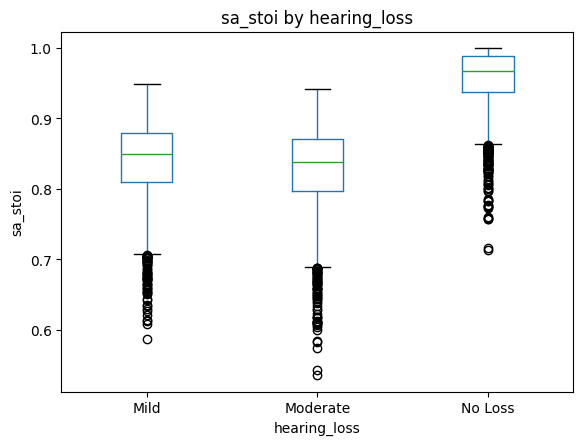

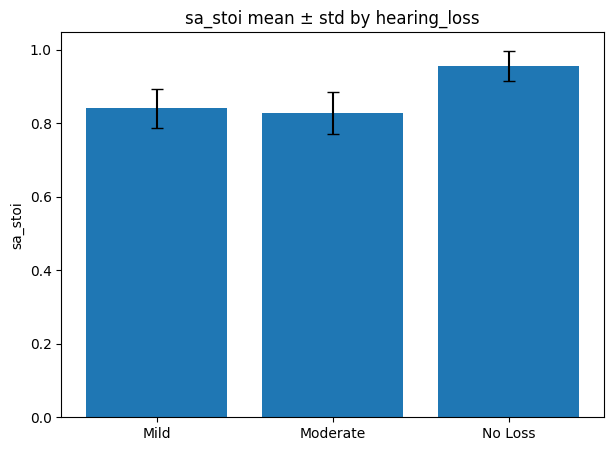

In [24]:
summarize_and_plot(df_scores2, score_col="sa_stoi", category_col="hearing_loss")

In [27]:
import pandas as pd

# Paths (edit if needed)
META_IN  = "metadata/train_metadata_with_duration.json"
SCORES_CSV = "sa_stoi_results_new.csv"   # your CSV with 'signal' and 'sa_stoi'
META_OUT = "metadata/train_metadata_with_sa_stoi.json"

# 1) Load metadata JSON (list of dicts)
df_meta = pd.read_json(META_IN)

# 2) Load scores CSV (let pandas infer delimiter; works for comma or tab)
df_scores = pd.read_csv(SCORES_CSV, sep=None, engine="python")

# 3) Keep only the columns we need and ensure numeric sa_stoi
df_scores = df_scores[["signal", "sa_stoi"]].copy()
df_scores["sa_stoi"] = pd.to_numeric(df_scores["sa_stoi"], errors="coerce")

# (optional) If there are duplicate 'signal' rows, keep the last
df_scores = df_scores.drop_duplicates(subset=["signal"], keep="last")

# 4) Left-merge on 'signal' to retain ALL original metadata rows
df_merged = df_meta.merge(df_scores, on="signal", how="left")

# 5) Save as a new JSON file (pretty, UTF-8, keep all original fields + sa_stoi)
df_merged.to_json(META_OUT, orient="records", force_ascii=False, indent=4)

print(f"✅ Wrote merged metadata with sa_stoi to: {META_OUT}")
print(f"Rows in original meta: {len(df_meta)} | with scores: {df_merged['sa_stoi'].notna().sum()}")


✅ Wrote merged metadata with sa_stoi to: metadata/train_metadata_with_sa_stoi.json
Rows in original meta: 8802 | with scores: 8802


### Visualization

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your merged metadata JSON or CSV
df = pd.read_json("metadata/train_metadata_with_sa_stoi.json")   # or read_csv if it's CSV
df = df.dropna(subset=["sa_stoi", "correctness"])
print(df[["sa_stoi", "correctness"]].head())


    sa_stoi  correctness
0  0.823365     0.000000
1  0.867202     0.166667
2  0.995445     0.777778
3  0.892558     0.000000
4  0.826040     0.000000


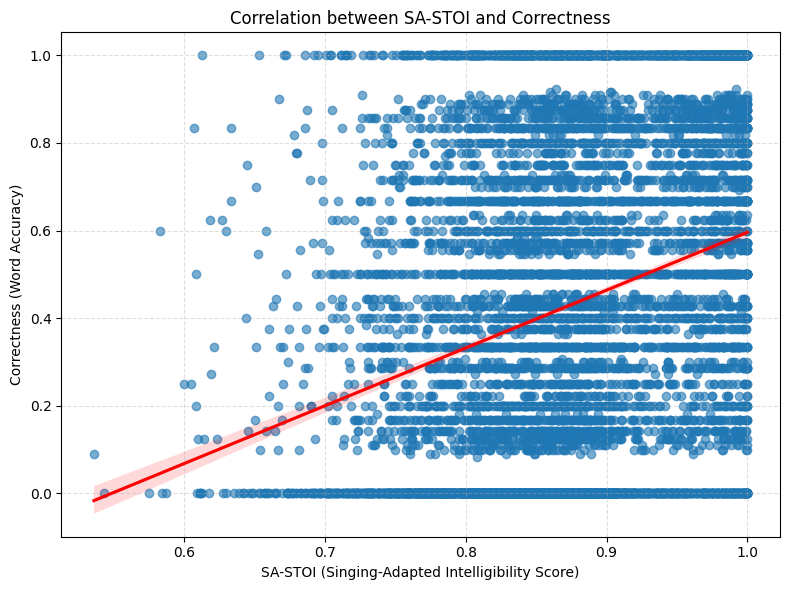

In [30]:
plt.figure(figsize=(8,6))
sns.regplot(
    x="sa_stoi", y="correctness",
    data=df,
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
plt.title("Correlation between SA-STOI and Correctness")
plt.xlabel("SA-STOI (Singing-Adapted Intelligibility Score)")
plt.ylabel("Correctness (Word Accuracy)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [31]:
corr = df["sa_stoi"].corr(df["correctness"])
print(f"Pearson correlation between SA-STOI and correctness: {corr:.3f}")


Pearson correlation between SA-STOI and correctness: 0.285


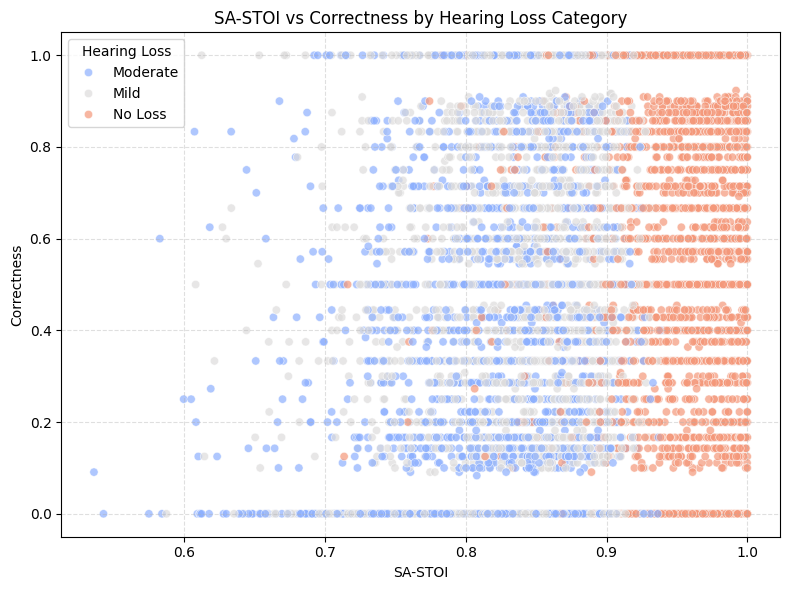

In [32]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="sa_stoi", y="correctness",
    hue="hearing_loss",
    data=df, palette="coolwarm", alpha=0.7
)
plt.title("SA-STOI vs Correctness by Hearing Loss Category")
plt.xlabel("SA-STOI")
plt.ylabel("Correctness")
plt.legend(title="Hearing Loss")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


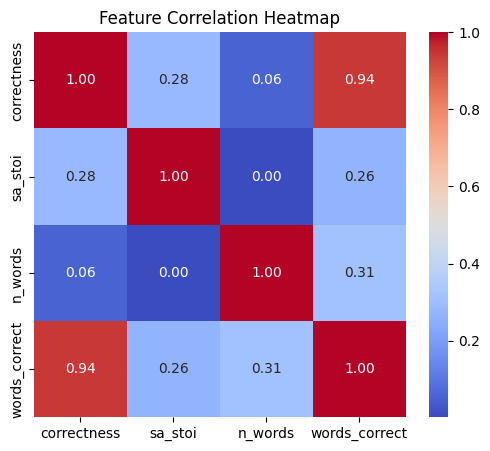

In [33]:
metrics = ["correctness", "sa_stoi", "n_words", "words_correct"]
corr_mat = df[metrics].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()
